# Import Abra

In [1]:
# For the development version now import abra.data has access to all the functions
# Later we might change that to more concise representation
import abra.data as abra
import numpy as np
import matplotlib.pyplot as plt
import abra.session as session
import ipywidgets as widgets
from IPython.display import display
import abra.visualization as vplt
%matplotlib inline

# Auto reload module for debuging purposes
%load_ext autoreload
%autoreload 2

## Read data

- 'read' function can read in .asc file converted from edf files
- 'mode' parament has two modes: default ('d') (**not availabe now**) and user define ('u'). Default mode means that the experiment code uses the tracker record and stop function for trial separation. For user define mode, you need to use regular expression in 'start_msg' and 'end_msg' to extract the starting and ending marker of each trial.


In [2]:
abra_data = abra.read('abra/test/asc/22205.asc', mode='u', start_msg=r"TRIAL \d{1,2} START", end_msg=r"TRIAL \d{1,2} END")
#abra_data = abra.read('abra/test/asc/88001.asc')

In [3]:
len(abra_data.timestamps)

1357067

In [4]:
len(abra_data.pupil_size)

1357067

# Available data properties

- timestamps: timestamps for each data point (might be duplicated depending on the sampling rate)
- pupil_size: the pupil size data
- movement: the eye movement data
- sample_rate: the sampling rate of the data
- messages (**not available now**): a dictionary of the 'MSG' lines in the data file, indexed by timestamps
- events: the eye tracker define events (eg. 'EBLINK R')
- trial_markers: the timestamps for the starting and ending of each trial (extracted from the read function)

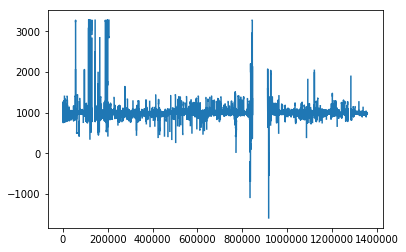

In [5]:
# Pupil size data
plt.plot(abra_data.pupil_size)

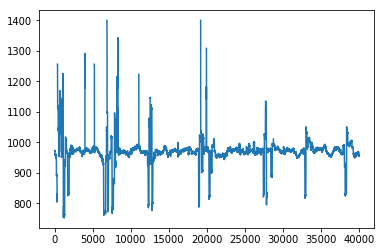

In [6]:
plt.plot(abra_data.pupil_size[:40000])

(0, 1280)

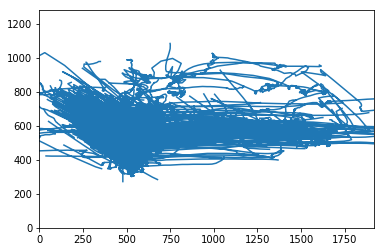

In [7]:
# movement data depending on screen size
plt.plot(abra_data.movement[0,:], abra_data.movement[1,:])
plt.xlim((0,1920))
plt.ylim((0,1280))

In [8]:
# event keys
abra_data.events.keys()

dict_keys(['EBLINK R', 'EFIX R', 'ESACC R', 'SBLINK R', 'SFIX R', 'SSACC R', 'EBLINK L', 'EFIX L', 'ESACC L', 'SBLINK L', 'SFIX L', 'SSACC L'])

In [9]:
# Sampling rate
abra_data.sample_rate

500

In [10]:
# trial markers
print(abra_data.trial_markers['start'][:10])
print(abra_data.trial_markers['end'][:10])

[394456, 406906, 418615, 432026, 448881, 462025, 472313, 481772, 490939, 500732]
[406906, 418615, 432026, 448881, 459736, 472313, 481772, 490939, 500732, 510344]


# Use cases

Currently only processing functions are developed for pupil size data

### 1. Indexing
you may extract certain part of the data using the numpy indexing

In [11]:
# Extract the second trial
index = (abra_data.timestamps > abra_data.trial_markers['start'][0]) & (abra_data.timestamps < abra_data.trial_markers['end'][0])

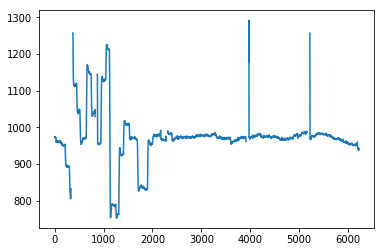

In [12]:
# Plot the pupil size
pupil_trial = abra_data.pupil_size[index]
plt.plot(pupil_trial)

(0, 1280)

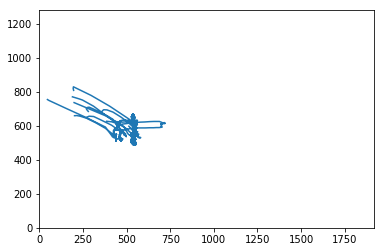

In [13]:
# Plot the movement (really depend on how large your screen is)
movement_trial = abra_data.movement[:,index]
plt.plot(movement_trial[0,:], movement_trial[1,:])
plt.xlim((0,1920))
plt.ylim((0,1280))

### 2. Remove eye blinks for pupil size data

Only linear interpolation is available now. You may choose your buffer size.

In [14]:
# Only linear interpolation is available at this point
cleaned_abra = abra.pupil_size_remove_eye_blinks(abra_data, buffer=50)
# You can do inplace interpolation as well
# abra.pupil_size_remove_eye_blinks(abra_data, inplace=True)

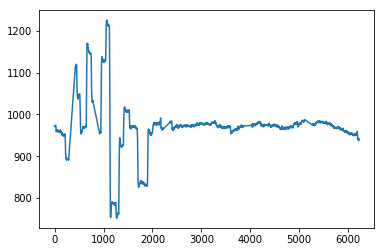

In [15]:
# Plot the pupil size
pupil_trial = cleaned_abra.pupil_size[index]
plt.plot(pupil_trial)

### 3. Timelocking to event markers

- event_timestamps: the list of timestamps for each event
- pre_event: the time (ms) before the event timestamps to include in an epoch
- post_event: the time (ms) after the event timestamps to include in an epoch
- baseline: the baseline window (ms) before the  pre_event used for baselining (using the mean and std)


In [16]:
# Events defined as trials
event_timestamps = np.array(cleaned_abra.trial_markers['start']) + 200  # Buffer for baslining

In [17]:
# pre_event = 0 starting from trial start, after 6000 ms, baseline period 200ms before pre_event
epochs = abra.pupil_size_time_locking(cleaned_abra, 
                                      event_timestamps = event_timestamps, 
                                      pre_event=0, 
                                      post_event=6000, 
                                      baseline=200)

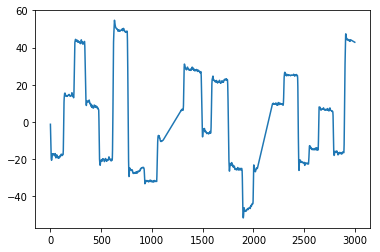

In [18]:
plt.plot(epochs[100,:])

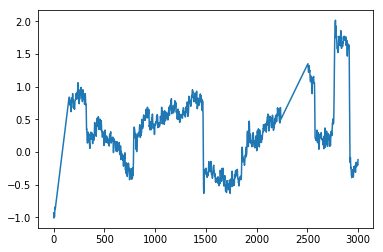

In [19]:
plt.plot(epochs[101,:])

In [20]:
# NO baselining
epochs = abra.pupil_size_time_locking(cleaned_abra, 
                                      event_timestamps = event_timestamps, 
                                      pre_event=0, 
                                      post_event=6000)

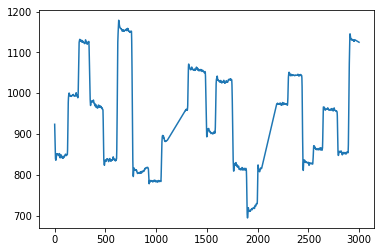

In [21]:
plt.plot(epochs[100,:])

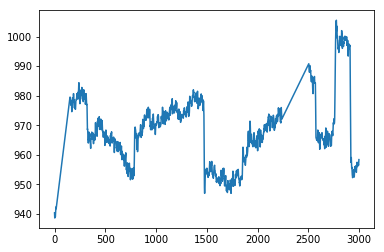

In [22]:
plt.plot(epochs[101,:])

# Data sanity check (ignore this if you are a user)

In [23]:
np.array(cleaned_abra.trial_markers['start'])

array([ 394456,  406906,  418615,  432026,  448881,  462025,  472313,
        481772,  490939,  500732,  510344,  519691,  529019,  537658,
        546520,  555930,  564682,  573377,  582106,  590878,  606031,
        658881,  730927,  747345,  763200,  786646,  843060,  860180,
        875527,  889876,  933355,  950165,  967292,  981563,  996023,
       1042719, 1063868, 1081230, 1096828, 1112767, 1204214, 1223907,
       1237796, 1252256, 1270883, 1290245, 1306739, 1323108, 1337353,
       1352617, 1370299, 1386390, 1399607, 1413483, 1427672, 1441721,
       1456333, 1473529, 1487245, 1505052, 1524113, 1543742, 1559327,
       1575891, 1591294, 1606115, 1621789, 1634687, 1648132, 1661299,
       1679063, 1693106, 1707441, 1722707, 1735527, 1750966, 1763911,
       1777780, 1793094, 1805546, 1830893, 1851271, 1863786, 1878794,
       1891913, 1903900, 1916428, 1931513, 1944090, 1956592, 1973345,
       1988316, 2000671, 2013359, 2026304, 2039472, 2051508, 2063842,
       2075634, 2087

In [24]:
def find_wired_timestamps(abra_data):
    ls = []
    for i in range(len(abra_data.timestamps)-1):
        if abra_data.timestamps[i]+2 != abra_data.timestamps[i+1]:
            ls.append(i)
            
    return ls

In [25]:
ls = find_wired_timestamps(cleaned_abra)

In [26]:
cleaned_abra.timestamps[ls]

array([ 459734,  599710,  658878,  776734,  905458, 1011960, 1112764,
       1131788, 1270880, 1290242, 1337350, 1365798, 1399604, 1487242,
       1521482, 1634684, 1675556, 1722704, 1818004, 1969278, 2102162,
       2237860, 2555902, 2615268, 2696808, 2727428, 2837452, 2872716,
       2973954, 2989204, 3108004, 3122326, 3309472, 3326834])

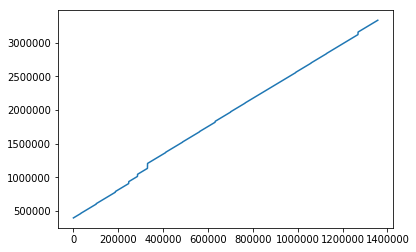

In [27]:
plt.plot(cleaned_abra.timestamps)

In [51]:
import abra.visualization as visual

%matplotlib tk
vis = visual.Visualization(sess)
vis.mainloop

AttributeError: 'Session' object has no attribute 'get_values'

(225, 225, 3)
847
427


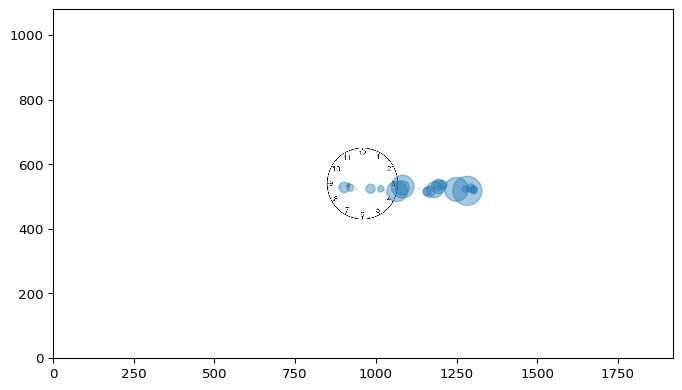

None


In [45]:
default_obj = abra.read("test/asc/1211NE1.asc")

# session.summary()
# default_app = Visualization(default_sess)
# default_app.mainloop()
#white-breates nuthach.jpg
#'/Users/akimaconnelly/Desktop/Research/Abra_Test_Code/git_hub_code/abra-eyetracking_tester/abra/libet_clock.png'

TypeError: Object does not appear to be a 8-bit string path or a Python file-like object

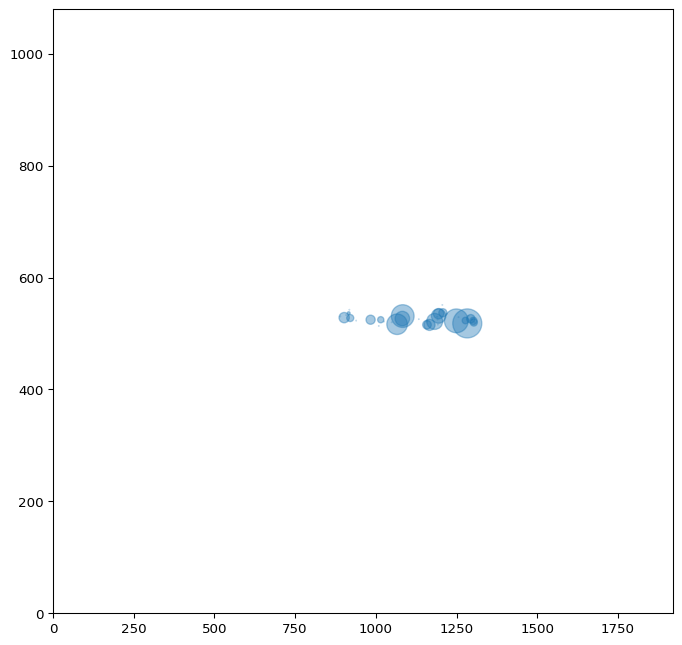

In [47]:
sess = default_obj.create_session()
print(sess.get_bubble_plot(1))

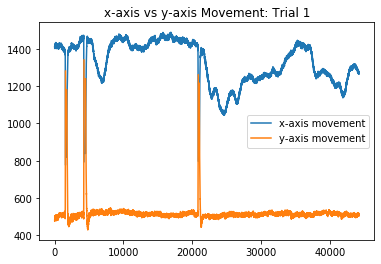

In [44]:
sess.plot_xy(1)

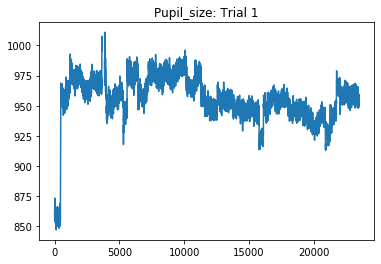

In [24]:
sess.plot_pupil_size(1)

In [86]:
x = sess.get_fixation()


In [87]:
x[0]

IndexError: too many indices for array

In [7]:
# x[0][4]

In [37]:
default_obj = abra.read("test/asc/1211NE1.asc"

In [38]:
default_obj.events

{}

In [27]:
dobj = abra.read("test/asc/1211NE1.asc")
dobj = abra.pupil_size_remove_eye_blinks(dobj)
print(sum(np.isnan(dobj.movement)))

0


In [ ]:
for na in np.isnan(dobj.movement)[0]:
    if na:
        print(na)
        